In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import missingno as miss
import datetime as date
import keras_tuner
import os
import random

SEED = 0

In [2]:
def set_seeds(seed=SEED):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    np.random.seed(seed)

In [3]:
def set_global_determinism(seed=SEED):
    set_seeds(seed=seed)

    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    
    tf.config.threading.set_inter_op_parallelism_threads(1)
    tf.config.threading.set_intra_op_parallelism_threads(1)

# Call the above function with seed value
set_global_determinism(seed=SEED)

### My thoughts behind this process:
We look for the ideal mix of variables for real data and our training method. As a result, we will utilize our data for our training process—all variables from 2001 to 2019—and so on, to cut down on needless complexity we will use lime to understand our models inner working for customized to our time series components


In [4]:
rain=pd.read_csv("D:\\wallpapers and photos\\paper\\ctg_SPEI_01_month.csv")

In [5]:
rain

,month,year,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data
0,1,1990,-1.196922,7.986048,NaN,NaN,NaN,2
1,2,1990,1.170883,38.400958,NaN,NaN,NaN,45
2,3,1990,1.408756,167.276733,NaN,NaN,NaN,176
3,4,1990,1.543604,459.069012,NaN,NaN,NaN,574
4,5,1990,-0.312795,451.979053,NaN,NaN,NaN,546
...,...,...,...,...,...,...,...,...
355,8,2019,-1.534795,369.220417,357.779294,309.905734,305.361677,446
356,9,2019,0.262943,372.324483,398.741260,308.893252,304.629744,309
357,10,2019,0.741661,172.972443,280.032311,305.788790,301.878652,348
358,11,2019,0.248811,34.913966,33.200685,302.645614,295.968013,9


<Axes: >

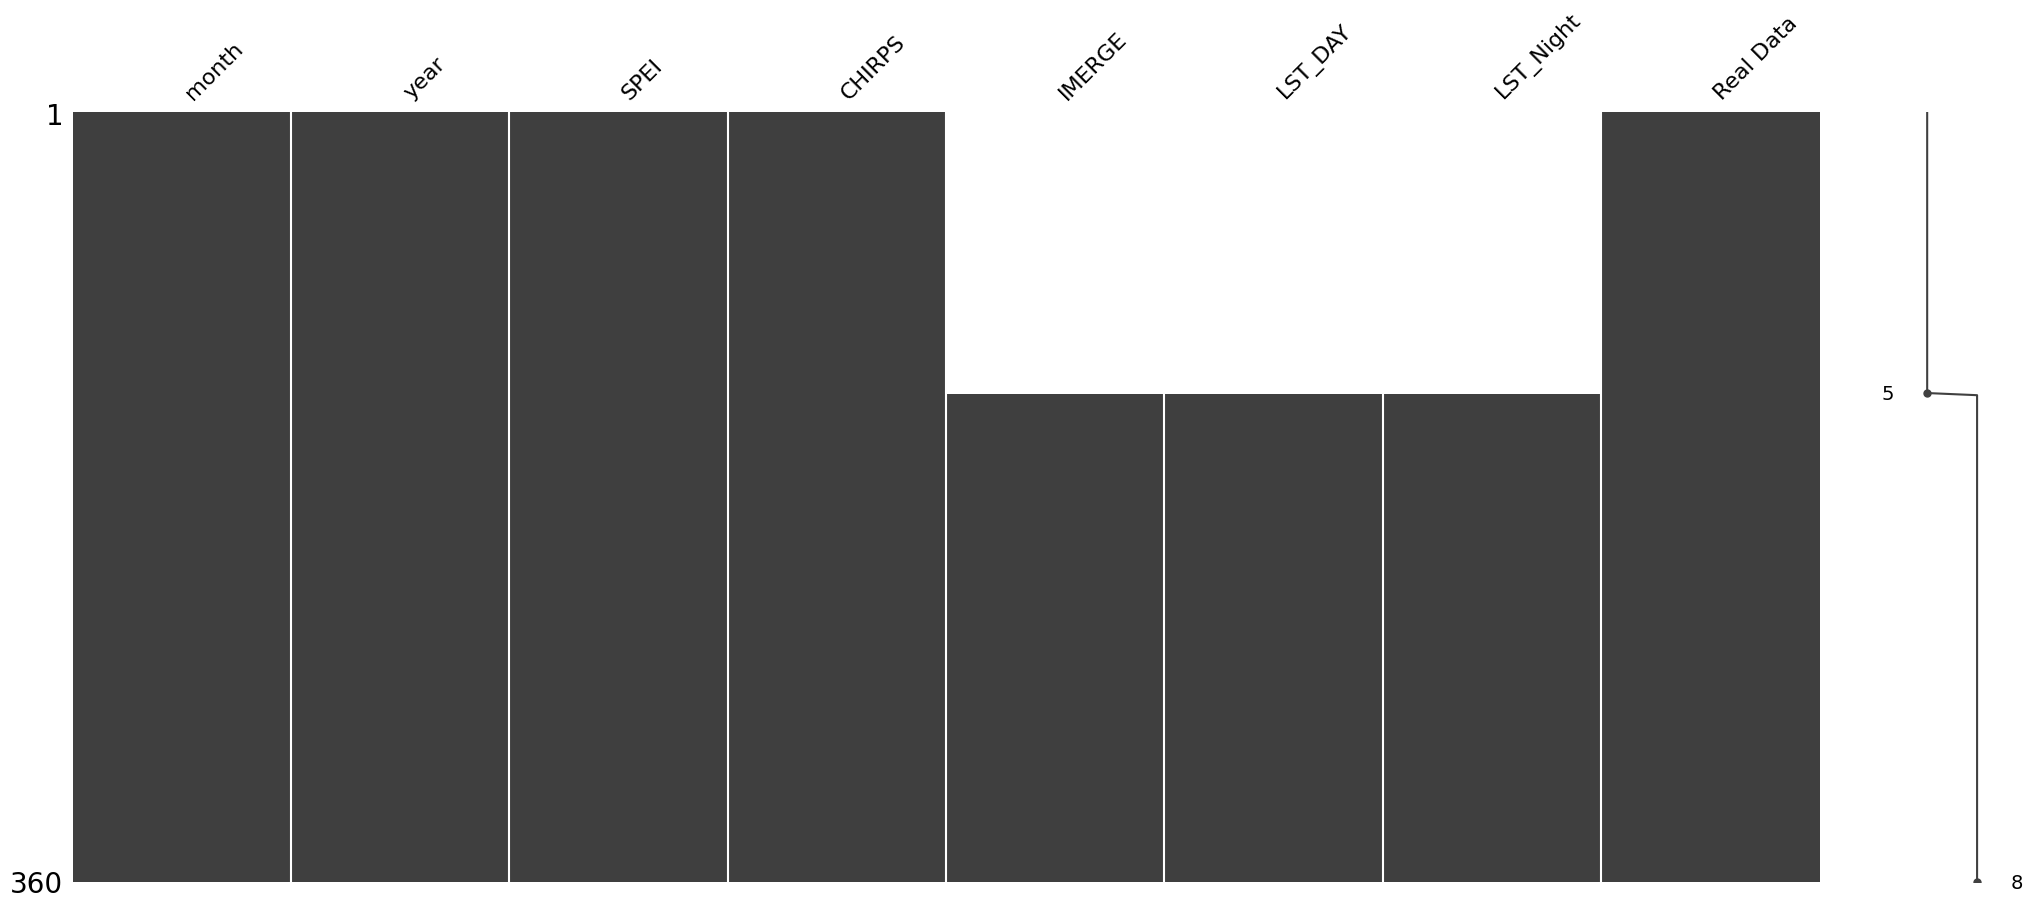

In [6]:
miss.matrix(rain)

In [7]:
rain["date"]=pd.to_datetime(rain[["year","month"]].assign(day=1))
rain

,month,year,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data,date
0,1,1990,-1.196922,7.986048,NaN,NaN,NaN,2,1990-01-01
1,2,1990,1.170883,38.400958,NaN,NaN,NaN,45,1990-02-01
2,3,1990,1.408756,167.276733,NaN,NaN,NaN,176,1990-03-01
3,4,1990,1.543604,459.069012,NaN,NaN,NaN,574,1990-04-01
4,5,1990,-0.312795,451.979053,NaN,NaN,NaN,546,1990-05-01
...,...,...,...,...,...,...,...,...,...
355,8,2019,-1.534795,369.220417,357.779294,309.905734,305.361677,446,2019-08-01
356,9,2019,0.262943,372.324483,398.741260,308.893252,304.629744,309,2019-09-01
357,10,2019,0.741661,172.972443,280.032311,305.788790,301.878652,348,2019-10-01
358,11,2019,0.248811,34.913966,33.200685,302.645614,295.968013,9,2019-11-01


In [8]:
rain=rain[["date","SPEI","CHIRPS","IMERGE","LST_DAY","LST_Night","Real Data"]]

In [9]:
rain

,date,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data
0,1990-01-01,-1.196922,7.986048,NaN,NaN,NaN,2
1,1990-02-01,1.170883,38.400958,NaN,NaN,NaN,45
2,1990-03-01,1.408756,167.276733,NaN,NaN,NaN,176
3,1990-04-01,1.543604,459.069012,NaN,NaN,NaN,574
4,1990-05-01,-0.312795,451.979053,NaN,NaN,NaN,546
...,...,...,...,...,...,...,...
355,2019-08-01,-1.534795,369.220417,357.779294,309.905734,305.361677,446
356,2019-09-01,0.262943,372.324483,398.741260,308.893252,304.629744,309
357,2019-10-01,0.741661,172.972443,280.032311,305.788790,301.878652,348
358,2019-11-01,0.248811,34.913966,33.200685,302.645614,295.968013,9


In [10]:
rain.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360 entries, 0 to 359
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       360 non-null    datetime64[ns]
 1   SPEI       360 non-null    float64       
 2   CHIRPS     360 non-null    float64       
 3   IMERGE     228 non-null    float64       
 4   LST_DAY    228 non-null    float64       
 5   LST_Night  228 non-null    float64       
 6   Real Data  360 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 19.8 KB


In [11]:
rain[134:]

,date,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data
134,2001-03-01,-0.966426,64.289428,41.102788,302.598259,293.031165,42
135,2001-04-01,0.007084,184.929458,217.211745,305.650489,296.822551,177
136,2001-05-01,1.156477,553.031958,385.470809,307.002426,300.381896,481
137,2001-06-01,-0.536249,688.813715,710.380893,304.700071,301.323211,729
138,2001-07-01,-0.957670,497.467203,531.412682,618.104018,605.228079,612
...,...,...,...,...,...,...,...
355,2019-08-01,-1.534795,369.220417,357.779294,309.905734,305.361677,446
356,2019-09-01,0.262943,372.324483,398.741260,308.893252,304.629744,309
357,2019-10-01,0.741661,172.972443,280.032311,305.788790,301.878652,348
358,2019-11-01,0.248811,34.913966,33.200685,302.645614,295.968013,9


In [12]:
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler
scale=SklearnTransformerWrapper(transformer=StandardScaler(),variables=["SPEI","CHIRPS","IMERGE","LST_DAY","LST_Night","Real Data"])
rain=scale.fit_transform(rain)
rain

,date,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data
0,1990-01-01,-1.042043,-1.062575,NaN,NaN,NaN,-1.010793
1,1990-02-01,1.348241,-0.955185,NaN,NaN,NaN,-0.879829
2,1990-03-01,1.588372,-0.500146,NaN,NaN,NaN,-0.480845
3,1990-04-01,1.724500,0.530126,NaN,NaN,NaN,0.731335
4,1990-05-01,-0.149522,0.505092,NaN,NaN,NaN,0.646056
...,...,...,...,...,...,...,...
355,2019-08-01,-1.383123,0.212885,0.286901,0.223601,0.330493,0.341488
356,2019-09-01,0.431681,0.223845,0.440996,0.175490,0.295738,-0.075770
357,2019-10-01,0.914944,-0.480035,-0.005577,0.027969,0.165104,0.043012
358,2019-11-01,0.417415,-0.967497,-0.934137,-0.121390,-0.115558,-0.989473


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set_theme(rc={'figure.figsize':(11.7,8.27)})
%matplotlib inline

<Axes: xlabel='date', ylabel='Real Data'>

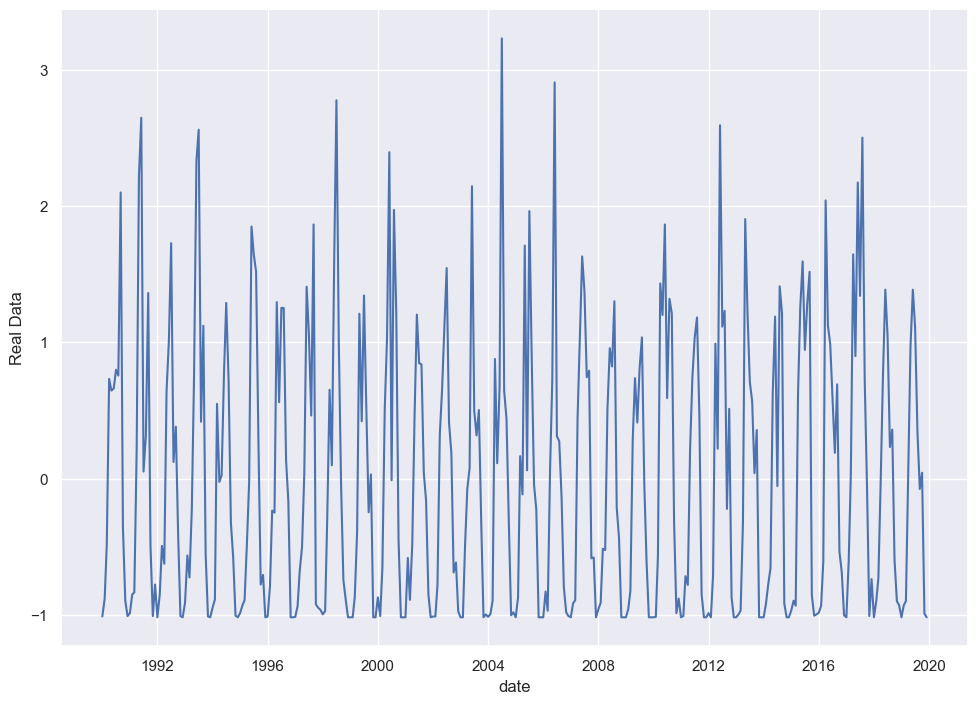

In [14]:
sns.lineplot(x="date",y="Real Data",data=rain)

<Axes: xlabel='date', ylabel='SPEI'>

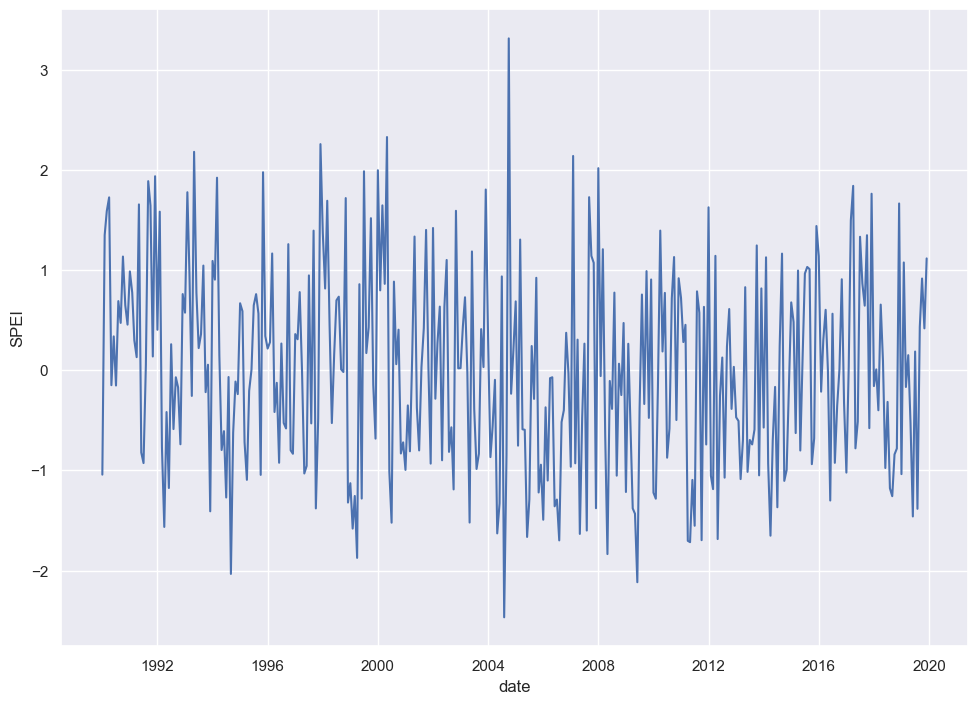

In [15]:
sns.lineplot(x="date",y="SPEI",data=rain)

<Axes: xlabel='date', ylabel='LST_Night'>

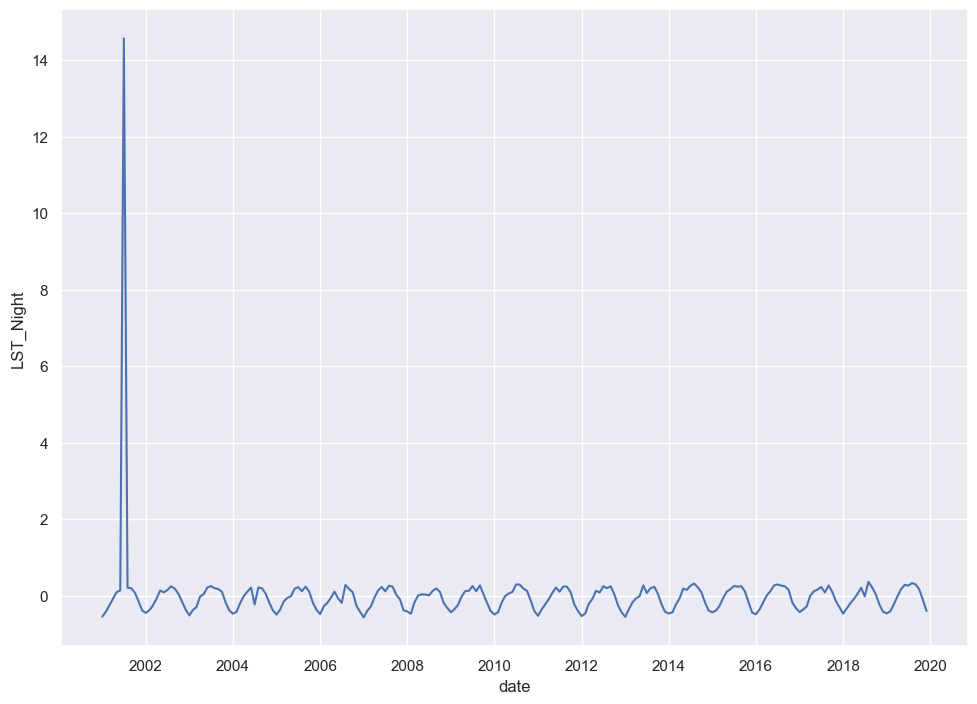

In [16]:
sns.lineplot(x="date",y="LST_Night",data=rain)

<Axes: >

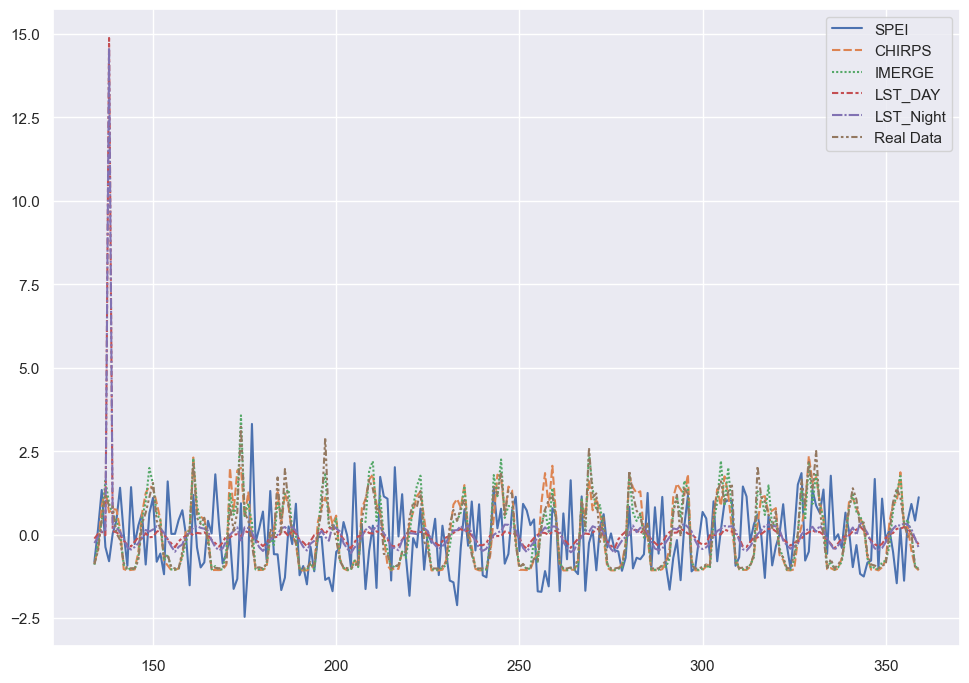

In [17]:
sns.lineplot(data=rain[134:])

### Cleaning the data with isolation forest

In [18]:
from sklearn.ensemble import IsolationForest
iso_forest = IsolationForest(contamination=0.1)
outliers = iso_forest.fit_predict(rain[134:].drop(["date"],axis=1))
rain_clean = rain[134:][outliers == 1]
rain_clean

,date,SPEI,CHIRPS,IMERGE,LST_DAY,LST_Night,Real Data
134,2001-03-01,-0.809359,-0.863777,-0.904410,-0.123641,-0.255012,-0.888966
135,2001-04-01,0.173393,-0.437817,-0.241902,0.021397,-0.074981,-0.477799
136,2001-05-01,1.333698,0.861894,0.391074,0.085640,0.094032,0.448087
137,2001-06-01,-0.375098,1.341317,1.613359,-0.023765,0.138730,1.203415
139,2001-08-01,0.031588,0.763109,0.592892,0.098557,0.209802,0.837934
...,...,...,...,...,...,...,...
355,2019-08-01,-1.383123,0.212885,0.286901,0.223601,0.330493,0.341488
356,2019-09-01,0.431681,0.223845,0.440996,0.175490,0.295738,-0.075770
357,2019-10-01,0.914944,-0.480035,-0.005577,0.027969,0.165104,0.043012
358,2019-11-01,0.417415,-0.967497,-0.934137,-0.121390,-0.115558,-0.989473


### Plot after treating outlier

<Axes: >

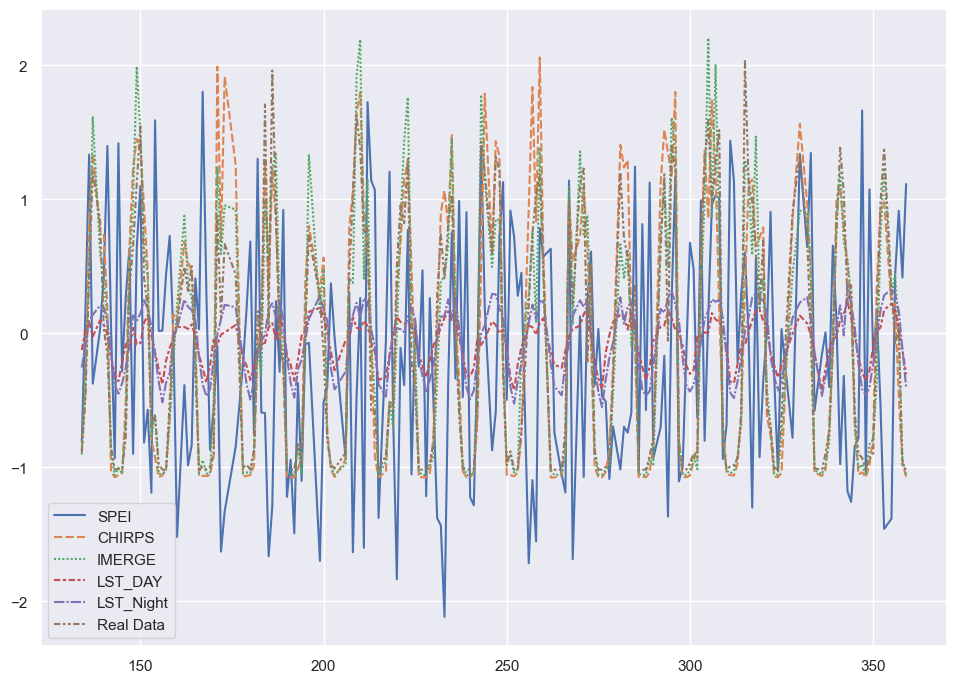

In [19]:
sns.lineplot(data=rain_clean)

In [20]:
train_set, test_set= np.split(rain_clean, [int(.6 *len(rain_clean))])

C:\Users\Lenovo\anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [21]:
train_set.shape,test_set.shape

((121, 7), (82, 7))

In [22]:
train_set, val_set= np.split(train_set, [int(.8 *len(train_set))])

In [23]:
train_set.shape,test_set.shape,val_set.shape

((96, 7), (82, 7), (25, 7))

In [24]:
x_train=train_set.drop(["date","Real Data"],axis=1)
y_train=train_set["Real Data"]

In [25]:
x_test=test_set.drop(["date","Real Data"],axis=1)
y_test=test_set["Real Data"]

In [26]:
x_val=val_set.drop(["date","Real Data"],axis=1)
y_val=val_set["Real Data"]

In [27]:
x_train.shape,y_train.shape

((96, 5), (96,))

In [28]:
x_test.shape,y_test.shape

((82, 5), (82,))

In [29]:
x_val.shape,y_val.shape

((25, 5), (25,))

### Let me walk You the through the process:
\\\ there the values from (2001-2019) and for each year it consists of 12 month.
### 1.  Sampling Rate:
---The interval at which you sample the data.
---It should reflect the granularity of the time sequence. If you are dealing with monthly data and want to maintain the sequence at a monthly level, the sampling rate can be 1, indicating that the data is sampled each month.
### 2. Sequence Length:
---The number of previous time steps to include in each input sequence.
---This determines how many previous time steps (months) you will use to predict the next. A reasonable starting point for monthly data might be 12, indicating that you use one year of data to make predictions.
### 3. Batch Size:
---The number of sequences to process together in each training iteration.
---Given that you only have 96 rows, a smaller batch size (like 1 or 2) would allow more frequent updates during training.

In [30]:
tf.random.set_seed(1234)
sampling_rate = 1
sequence_length =12
#delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 1
train_dataset=keras.utils.timeseries_dataset_from_array(data=x_train,targets=y_train,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)
test_dataset=keras.utils.timeseries_dataset_from_array(data=x_test,targets=y_test,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)
val_dataset=keras.utils.timeseries_dataset_from_array(data=x_val,targets=y_val,sampling_rate=sampling_rate,sequence_length=sequence_length,shuffle=True,batch_size=batch_size)

In [31]:
from keras import layers

In [32]:
def r2_score(y_true, y_pred):
    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    return 1 - ss_res / (ss_tot + tf.keras.backend.epsilon())

### RNN model architechture

In [33]:
best_architechture_rnn=keras.models.load_model("rain_architechture_new_tuned.keras")

In [34]:
best_architechture_rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12, 5)]      0           []                               
                                                                                                  
 lstm (LSTM)                    (None, 12, 384)      599040      ['input_1[0][0]']                
                                                                                                  
 lstm_1 (LSTM)                  (None, 12, 416)      1332864     ['lstm[0][0]']                   
                                                                                                  
 dense_1 (Dense)                (None, 12, 352)      146784      ['lstm_1[0][0]']                 
                                                                                              

In [35]:
model_rnn_new= keras.models.load_model("rain_encode_new_tuned_final.keras",custom_objects={'r2_score': r2_score})

In [36]:
results=model_rnn_new.evaluate(test_dataset)


71/71 [==============================] - 12s 131ms/step - loss: 0.2631 - rmse: 0.4933 - mae: 0.3751


In [37]:
from tabulate import tabulate
table = [
    ["Algorithm",  "RNN"],
    ["RMSE", results[1]],
    ["MAE", results[2]]
]

# Display the table
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

╒═════════════╤══════════╕
│ Algorithm   │      RNN │
╞═════════════╪══════════╡
│ RMSE        │ 0.493327 │
├─────────────┼──────────┤
│ MAE         │ 0.37512  │
╘═════════════╧══════════╛


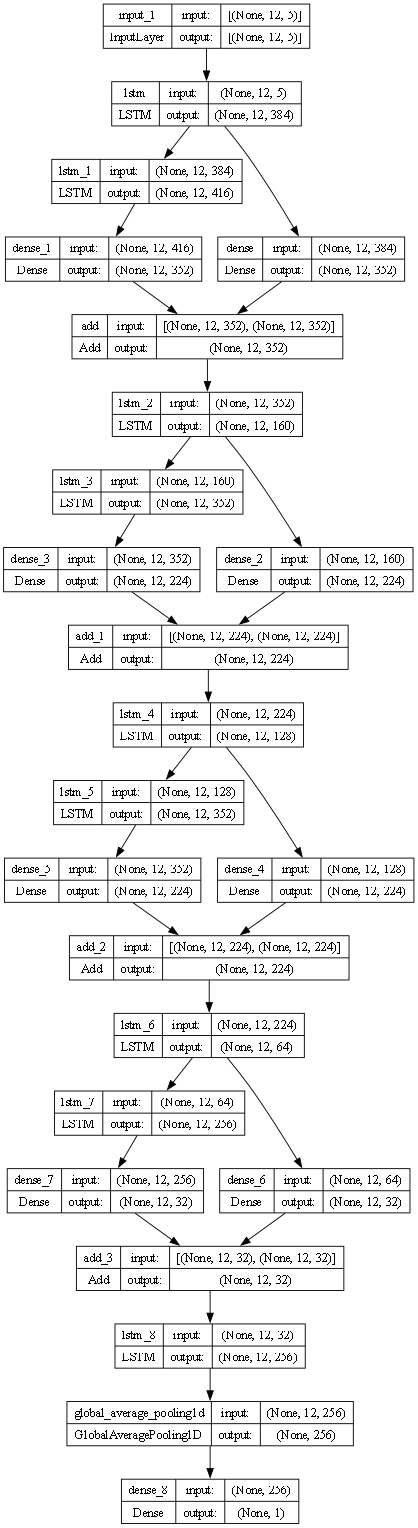

In [38]:
keras.utils.plot_model(model_rnn_new, show_shapes=True,dpi=65)

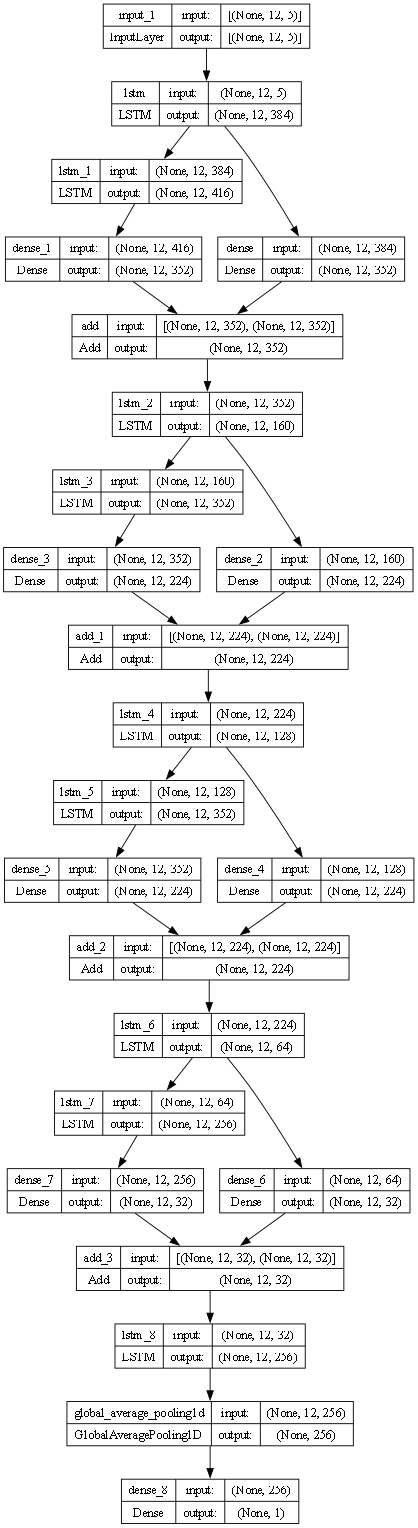

In [39]:
keras.utils.plot_model(best_architechture_rnn, show_shapes=True,dpi=65)

In [42]:
import lime
import lime.lime_tabular
import numpy as np

import numpy as np
import lime
import lime.lime_tabular

feature_names = ["SPEI","CHIRPS","IMERGE","LST_DAY","LST_Night"]


import numpy as np
import lime
import lime.lime_tabular

# Convert the dataset to arrays
x_train_array, y_train_array = [], []

for x, y in train_dataset:
    x_train_array.append(x.numpy())  # Keep the original shape
    y_train_array.append(y.numpy())

x_train_seq = np.array(x_train_array)
y_train_seq = np.array(y_train_array)

# Custom perturbation function for time-series
def perturb_timeseries(data_instance):
    perturbed_instance = data_instance.copy()
    num_timesteps = perturbed_instance.shape[0]
    # Randomly mask a third of the time steps
    time_steps_to_perturb = np.random.choice(num_timesteps, size=int(num_timesteps / 3), replace=False)
    perturbed_instance[time_steps_to_perturb, :] = 0  # Zero-out the selected time steps
    return perturbed_instance

# Wrapper function for LIME to generate perturbations and call the LSTM model
def timeseries_predict_wrapper(data_instances):
    predictions = []
    for instance in data_instances:
        instance = instance.reshape(1, sequence_length, len(feature_names))  # Reshape for LSTM
        prediction = model_rnn_new.predict(instance)
        predictions.append(prediction[0])  # Assuming a single prediction for the entire sequence
    return np.array(predictions)

# Initialize LIME explainer with feature names
explainer = lime.lime_tabular.LimeTabularExplainer(
    x_train_seq.reshape(x_train_seq.shape[0], -1),  # Flatten for LIME initialization
    mode='regression',
    feature_names=[f'{feature}_{t}' for t in range(sequence_length) for feature in feature_names],  # Combine feature names and time steps
    verbose=True
)

# Choose a specific instance from the test dataset to explain
x_test_array = []
for x, y in test_dataset:
    x_test_array.append(x.numpy())

x_test_seq = np.array(x_test_array)

# Select a specific instance from the test data to explain
instance_to_explain = x_test_seq[0]

# Explain the model's prediction for this instance
exp = explainer.explain_instance(
    instance_to_explain.reshape(-1),  # Flatten for LIME, but perturbed in original shape
    timeseries_predict_wrapper,
    num_features=sequence_length * len(feature_names),  # Number of time steps and features
    top_labels=1
)

# Display the explanation
exp.show_in_notebook()
exp.save_to_file('lime_explanation.html')

1/1 [==============================] - 0s 162ms/step
Intercept -0.47805352200515877
Prediction_local [0.58784043]
Right: 0.67581147
